# LEAFToolbox for Sites
Applies the LEAF-ToolBox for mapping vegetation using satellite imagery over a list of sites, each defined using time stamped vector geographical objects.
Cite as Fernandes, R. et al., 2021, "LEAF Toolbox", Canada Centre for Remote Sensing, https://github.com/rfernand387/LEAF-Toolbox/wiki, DOI: 10.5281/zenodo.4321298.


LEAF currently supports two algorithms: 

SL2PV0 is the algorithm defined by Weiss and Baret (2016) with an update in Weiss and Baret (2020).  


SL2PV1.1 defined in  Fernandes et al. 2024 that attempts to correct for biases in crown and shoot clumping over forests observed in SL2PV0.


Refer to https://github.com/rfernand387/LEAF-Toolbox/tree/master/Source-Python for configuration of anaconda environment.


Weiss, M. and Baret, F. 2016. S2ToolBox Level 2 products: LAI, FAPAR, FCOVER, 1.1. ed.
Institut National de la Recherche Agronomique, Avignon, France. https://step.esa.
int/docs/extra/ATBD_S2ToolBox_L2B_V1.1.pdf.

Weiss, M., and Baret, F., 2020. S2ToolBox Level 2 Products: LAI, FAPAR, FCOVER, 2.0. ed.
Institut National de la Recherche Agronomique, Avignon, France. https://step.esa.
int/docs/extra/ATBD_S2ToolBox_L2B_V2.0.pdf.

Fernandes, R., Canisius, F., Harvey, K., Hong, G., MacDougall, C., Shah, H., Sun, L., 2024. Evidence of a bias-variance trade off when correcting for bias in Sentinel 2 forest LAI retrievals using radiative transfer models. Remote Sensing of EnvironmentRemote Sens. Environ. 305. doi:10.1016/j.rse.2024.114060.


## Setup Environment

In [ ]:
# Provide your GEE authentificaton
import ee
ee.Authenticate(force=True)

In [3]:
ee.Initialize()

NameError: name 'ee' is not defined

In [7]:
# Uncomment this if you are modifying modules
# %load_ext autoreload
# %autoreload 2

In [8]:
# import LEAF modules
import LEAFv3

# # import algorithm definitions
import SL2PV0 
import SL2PV1
import SL2PV1MIX
import SL2PV1DBF
import SL2PV1ENF
import SL2PV1_1
import SL2PV1_1MIX
import SL2PV1_1DBF
import SL2PV1_1ENF

C:\Users\rfernand\AppData\Local\anaconda3\envs\eeValidation\Lib\site-packages\ee\deprecation.py:209: DeprecationWarning: 

Attention required for JRC/GSW1_0/GlobalSurfaceWater! You are using a deprecated asset.
To make sure your code keeps working, please update it.
Learn more: https://developers.google.com/earth-engine/datasets/catalog/JRC_GSW1_0_GlobalSurfaceWater

  warnings.warn(warning, category=DeprecationWarning)


In [16]:
import LEAFv4

## Process Sites with output as a Pandas Data Frame

Sites correspond to readable Google Earth Engine Feature collections under which samples will be extracted.
If the features have time stamps as properties the sampling interval can be restricted on a feature by feature basis.
Otherwise the sampling interval must be specified the same for all features.

In [1]:
# List of GEE feature collections
# siteList=["projects/ee-modis250/assets/FO_HWSW_Buf60_lonlat"]
# siteList=["projects/ee-modis250/assets/northern_filtered_abandoned_wells","projects/ee-modis250/assets/northern_reference_buffers_matched"]
# siteList=["projects/ee-modis250/assets/sample_wells","projects/ee-modis250/assets/sample_wells_reference_buffers"]
siteList=['projects/ee-modis250/assets/Bonney_SiteswithDates_2019']
# siteList=["projects/ee-modis250/assets/sites_3013_buffer150m"]
# siteList=["projects/ee-ronnyale/assets/random_sample_1000_filtered_abandoned_wells"]
siteList=["projects/ee-modis250/assets/Anderson/Anderson_LAI-2017-2018_May16to24","projects/ee-modis250/assets/Anderson/Anderson_LAI-2017-2018_Aug16to24"]

## Run LEAF 

In [14]:
# Function definition
#
# LEAF.sampleSites
# sitesDictionary = LEAF.sampleSites( siteList, \
#                                     imageCollectionName="COPERNICUS/S2_SR_HARMONIZED",\
#                                     algorithm=SL2PV0, \
#                                     variableName="LAI",\
#                                     maxCloudcover=90,\
#                                     outputScaleSize=20,\
#                                     inputScaleSize=20,\
#                                     bufferSpatialSize = 0,\
#                                     bufferTemporalSize = [0,0], 
#                                     subsamplingFraction=1.
#                                     numPixels=0,
#                                     outputFileName=None,
#                                     feature_range=[0,np.nan])
#
# Applies a LEAF toolbox algorithm to map a canopy variable for all clear sky unmasked pixels from an input image collection
# falling within the spatial and temporal extents of features in a list of sites.  The spatial extent of features is defined by their GEE geometry.  
# The temporal extent of features is defined by their "system:time_start" and "system:time_end" properties or user defined otherwise.
#
# Parameters:
#
# siteList: list of readable GEE feature collection assets.  Features must have a system:time_start and system:time_end property.
# imageCollectionName: input image collection name from one of the list defined by GEE
#                 ["COPERNICUS/S2_SR_HARMONIZED","COPERNICUS/S2_SR_HARMONIZED_10m","LANDSAT/LC08/C02/T1_L2","LANDSAT/LC09/C02/T1_L2","NASA/HLS/HLSL30/v002"]
# algorithm: python module specifying LEAF algorithm to apply , currently one of list ["SL2PV0","SL2PV1"]
# variableName: variable to be mapped from one of the list ["ALBEDO","FAPAR","FCOVER","LAI","CWC","CCC","DASF"] defined by https://github.com/rfernand387/LEAF-Toolbox/wiki/Visualisation-Outputs              
# maxCloudCover: maximum input image cloud cover percentage [0,100]
# filterSize: width (m) of square filter applied to output
# scaleSize: scale (m) applied to output imagery after applying algorithm (refer to https://developers.google.com/earth-engine/guides/scale)
# inputScaleSize: scale (m) applied to input imagery before applying algorithm (refer to https://developers.google.com/earth-engine/guides/scale)
# bufferSpatialSize: width (m) of spatial buffer applied to features prior to sampling
# bufferTemporalSize: dilation (d) of start and end time of sampled features OR temporal interval ["YYYY-MM-DD","YYYY-MM-DD"[ of start and end of time interval to sample.  
# subsamplingFraction: fraction (0 to 1) of pixels to sample within a feature on any given image
# numPixels: maximum number of pixels to sample within a feature, overrides subsampling fraction
# outputPathName: name of path for output file, defaules to current working directory
# feature_range: range of features in each site GEE feature collection to sample, use this if you have one site with many features and want only a few of them                                                                                                                        
# Output:
#
# Results in a .pkl file with a pandas dictionary for each site in siteList:
#
# sitesDictionary: dictionary with keys corresponding to sites and structure.  The value of each key is a dictionary with two keys:
#                     'feature' : properties of the sampled feature
#                     'SL2PV0' or 'SL2PV1' : a pandas data frame where columns correspond to algorithm output properties and rows correspond to a retrieval within the time and spatial interval of the feature               

In [2]:
HLSL30LAIV0_2025= LEAFv4.sampleSites(siteList, 
                                    sensorName = 'S2', 
                                    imageCollectionName="COPERNICUS/S2_SR_HARMONIZED",
                                    outputPath='leafoutput8',
                                    algorithm=SL2PV0, \
                                    variableName="LAI",
                                    featureRange=[0,10], 
                                    maxCloudcover=80,
                                    outputScaleSize=20,
                                    exportFlag='CloudStorage',
                                    prefixProperty='system:index',
                                    inputScaleSize=20,
                                    bufferSpatialSize=0,
                                    subsamplingFraction=1,
                                    numPixels=0,
                                    bufferTemporalSize=['2000-07-01','2020-09-01'],
                                    calendarRange=[5,9,'month'],
                                    timeZone='Etc/GMT+6',
                                    shardSize='YS')

NameError: name 'LEAFv4' is not defined

In [37]:
HLSL30LAIV0_2025= LEAFv4.imageSites(siteList, \
                                    imageCollectionName="COPERNICUS/S2_SR_HARMONIZED",\
                                    sensorName = 'S2', \
                                    outputPath='leafoutput8',\
                                    algorithm=SL2PV0, \
                                    variableName="LAI",\
                                    featureRange=[0,1], \
                                    maxCloudcover=80,\
                                    outputScale=20,\
                                    exportFlag='CloudStorage',
                                    prefixProperty='system:index',
                                    inputScale=20,
                                    bufferSpatialSize=4000,
                                    bufferTemporalSize=['2020-07-01','2021-09-01'],
                                    calendarRange=[7,8,'month'],
                                    timeZone='Etc/GMT+6',
                                    shardSize='YS')

STARTING LEAF.imageSites using  COPERNICUS/S2_SR_HARMONIZED
S2
Site:  projects/ee-modis250/assets/Bonney_SiteswithDates_2019  with  27  features.
Processing Features: from 0 to 1
Feature n°: 0/1  -- startDate: 2020-07-01 00:00:00 -- endDate: 2021-09-01 00:00:00
----------------------------------------------------------------------------------------------------------
Sampling from  2020-07-01 00:00:00  to  2021-09-01 00:00:00
Export task started with ID: GCF2D2YLLYD7QHQ3FAONUMLL
Export task started with ID: XYV26S7XCQ4LHZRFCMCAA2AR
Export task started with ID: LQTZSRUAAQUQUOKYFUBILDNH
Export task started with ID: YGLRW3SU6PIS5H6ULNHWMCR3
Export task started with ID: BCX6GGO236VUXK2DA4XL3ULQ
Export task started with ID: Y75BDTKYZYNWYY434G4A5YVV
Export task started with ID: AMZ3EPCAUPOXF6MY33VG6ZMV
Export task started with ID: DQ5ZU645HP2XOXA62OMN76Q6
Export task started with ID: ZTEMVAT5KMVX7J46FY6MJ5IH
Export task started with ID: XOPGJL2GXVEMXFUZHLUQTNTS
Export task started with ID: 55

In [96]:
HLSL30LAIV0_2025= LEAFv4.sampleSites(siteList, \
                                    outputPath='leafoutput5',\
                                    imageCollectionName="NASA/HLS/HLSS30/v002",\
                                    outputName = 'HLSS30', \
                                    algorithm=SL2PV0, \
                                    variableName="LAI",\
                                    maxCloudcover=80,
                                    outputScaleSize=30,\
                                    inputScaleSize=30,\
                                    bufferSpatialSize = 0,\
                                    bufferTemporalSize =[-7,7],  \
                                    subsamplingFraction = 0.99,\
                                    featureRange=[0,1], \
                                    calendarRange=[1,12,'month'], \
                                    exportFlag='CloudStorage')

STARTING LEAF IMAGE for  NASA/HLS/HLSS30/v002
Site:  projects/ee-modis250/assets/Bonney_SiteswithDates_2019  with  27  features.
Data sampling for features: from 0 to 1
Feature n°: 0/1  -- startDate: 2019-08-23 20:00:00 -- endDate: 2019-09-06 20:00:00
----------------------------------------------------------------------------------------------------------
Sampling from  2019-08-23 20:00:00  to  2019-09-07 20:00:00
Export task started with ID: VDXNKOJMX7WI2IOF5FS434S3

DONE LEAF SITE



In [10]:
HLSL30LAIV0_2025= LEAFv3.sampleSites(siteList, \
                                    imageCollectionName="NASA/HLS/HLSL30/v002",\
                                    outputName = 'HLSL30', \
                                    algorithm=SL2PV0, \
                                    variableName="LAI",\
                                    maxCloudcover=80,
                                    outputScaleSize=30,\
                                    inputScaleSize=30,\
                                    bufferSpatialSize = 0,\
                                    bufferTemporalSize =["2013-04-01","2025-09-11"],  \
                                    subsamplingFraction = 0.99,\
                                    feature_range=[0,3014], \
                                    calendar_Range=[7,9,'month'], \
                                    exportFlag='CloudStorage')

STARTING LEAF IMAGE for  NASA/HLS/HLSL30/v002
Output file: d:\LEAF_production\random_sample_1000_filtered_abandoned_wells_NASA_HLS_HLSL30_v002_LAI_0_3014_SL2PV0_2013_04_01_00h_04mn_2025_09_19_16h_09mn.pkl
Site:  projects/ee-ronnyale/assets/random_sample_1000_filtered_abandoned_wells  with  1000  features.
Data sampling for features: from 0 to 1000
Feature n°: 0/1000  -- startDate: 2013-04-01 00:00:00 -- endDate: 2025-09-11 00:00:00
----------------------------------------------------------------------------------------------------------
Sampling from  2013-04-01 00:00:00  to  2025-09-12 00:00:00
Export task started with ID: ZKWIWS4WOTXRPDZOP3DQGMHE
Feature n°: 1/1000  -- startDate: 2013-04-01 00:00:00 -- endDate: 2025-09-11 00:00:00
----------------------------------------------------------------------------------------------------------
Sampling from  2013-04-01 00:00:00  to  2025-09-12 00:00:00
Export task started with ID: WW6VD5M52W76Q3JQGKWF5UPS
Feature n°: 2/1000  -- startDate: 20

In [11]:
S20LAIV0_2025= LEAFv3.sampleSites(siteList, \
                                    imageCollectionName="COPERNICUS/S2_SR_HARMONIZED",\
                                    algorithm=SL2PV0, 
                                    variableName="LAI",\
                                    maxCloudcover=80,
                                    outputScaleSize=20,\
                                    inputScaleSize=20,\
                                    bufferSpatialSize = 0,\
                                    bufferTemporalSize =["2016-04-01","2025-09-11"],  \
                                    subsamplingFraction = 0.99,\
                                    feature_range=[0,3014], \
                                    calendar_Range=[7,9,'month'], \
                                    exportFlag='CloudStorage')

TypeError: sampleSites() missing 1 required positional argument: 'outputName'

In [223]:
S20LAIV0_2025= LEAFv3.sampleSites(siteList, \
                                    imageCollectionName='LANDSAT/LE07/C02/T1_L2',\
                                    algorithm=SL2PV0, 
                                    variableName="LAI",\
                                    maxCloudcover=80,
                                    outputScaleSize=20,\
                                    inputScaleSize=20,\
                                    bufferSpatialSize = 0,\
                                    bufferTemporalSize =["2016-04-01","2023-09-11"],  \
                                    subsamplingFraction = 0.99,\
                                    feature_range=[0,1], \
                                    calendar_Range=[7,9,'month'], \
                                    exportFlag='CloudStorage')

STARTING LEAF IMAGE for  LANDSAT/LE07/C02/T1_L2
Output file: d:\LEAF_production\sites_3013_buffer150m_LANDSAT_LE07_C02_T1_L2_LAI_0_1_SL2PV0_2016_04_01_00h_04mn_2025_09_16_11h_09mn.pkl
Site:  projects/ee-modis250/assets/sites_3013_buffer150m  with  3013  features.
Data sampling for features: from 0 to 1
Feature n°: 0/1  -- startDate: 2016-04-01 00:00:00 -- endDate: 2023-09-11 00:00:00
----------------------------------------------------------------------------------------------------------
Sampling from  2016-04-01 00:00:00  to  2023-09-12 00:00:00
Export task started with ID: WBR6FJTBS4HQP43KIUFTQWZX

DONE LEAF SITE



In [ ]:
HLSS30fCOVERV0= LEAFv2.sampleSites(siteList, \
                                                imageCollectionName="NASA/HLS/HLSS30/v002",\
                                                algorithm=SL2PV0, 
                                                variableName="fCOVER",\
                                                maxCloudcover=90,
                                                outputScaleSize=30,\
                                                inputScaleSize=30,\
                                                bufferSpatialSize = 0,\
                                                bufferTemporalSize =["2016-01-01","2024-12-31"],  \
                                                subsamplingFraction = 0.99,\
                                                feature_range=[0,5])

HLSL30fCOVERV0= LEAFv2.sampleSites(siteList, \
                                                imageCollectionName="NASA/HLS/HLSL30/v002",\
                                                algorithm=SL2PV0, 
                                                variableName="fCOVER",\
                                                maxCloudcover=90,
                                                outputScaleSize=30,\
                                                inputScaleSize=30,\
                                                bufferSpatialSize = 0,\
                                                bufferTemporalSize =["2013-01-01","2024-12-31"],  \
                                                subsamplingFraction = 0.99,\
                                                feature_range=[0,5])
S2fCOVERV0= LEAFv2.sampleSites(siteList, \
                                                imageCollectionName="COPERNICUS/S2_SR_HARMONIZED",\
                                                algorithm=SL2PV0, 
                                                variableName="fCOVER",\
                                                maxCloudcover=90,
                                                outputScaleSize=20,\
                                                inputScaleSize=20,\
                                                bufferSpatialSize = 0,\
                                                bufferTemporalSize =["2016-01-01","2024-12-31"],  \
                                                subsamplingFraction = 0.99,\
                                                feature_range=[0,5])

In [ ]:
HLSS30fCOVER= LEAFv2.sampleSites(siteList, \
                                                imageCollectionName="NASA/HLS/HLSS30/v002",\
                                                algorithm=SL2PVMIX, 
                                                variableName="fCOVER",\
                                                maxCloudcover=90,
                                                outputScaleSize=30,\
                                                inputScaleSize=30,\
                                                bufferSpatialSize = 0,\
                                                bufferTemporalSize =["2016-01-01","2024-12-31"],  \
                                                subsamplingFraction = 0.99,\
                                                feature_range=[0,5])

HLSL30fCOVER= LEAFv2.sampleSites(siteList, \
                                                imageCollectionName="NASA/HLS/HLSL30/v002",\
                                                algorithm=SL2PVMIX, 
                                                variableName="fCOVER",\
                                                maxCloudcover=90,
                                                outputScaleSize=30,\
                                                inputScaleSize=30,\
                                                bufferSpatialSize = 0,\
                                                bufferTemporalSize =["2013-01-01","2024-12-31"],  \
                                                subsamplingFraction = 0.99,\
                                                feature_range=[0,5])
S2fCOVER= LEAFv2.sampleSites(siteList, \
                                                imageCollectionName="COPERNICUS/S2_SR_HARMONIZED",\
                                                algorithm=SL2PVMIX, 
                                                variableName="fCOVER",\
                                                maxCloudcover=90,
                                                outputScaleSize=20,\
                                                inputScaleSize=20,\
                                                bufferSpatialSize = 0,\
                                                bufferTemporalSize =["2016-01-01","2024-12-31"],  \
                                                subsamplingFraction = 0.99,\
                                                feature_range=[0,5])

In [300]:
# HLSS30LAIV0= LEAFv2.sampleSites(siteList, \
#                                                 imageCollectionName="NASA/HLS/HLSS30/v002",\
#                                                 algorithm=SL2PV0, 
#                                                 variableName="LAI",\
#                                                 maxCloudcover=90,
#                                                 outputScaleSize=30,\
#                                                 inputScaleSize=30,\
#                                                 bufferSpatialSize = 0,\
#                                                 bufferTemporalSize =["2016-01-01","2024-12-31"],  \
#                                                 subsamplingFraction = 0.99,\
#                                                 feature_range=[0,5])

HLSL30LAIV0= LEAFv2.sampleSites(siteList, \
                                                imageCollectionName="NASA/HLS/HLSL30/v002",\
                                                algorithm=SL2PV0, 
                                                variableName="LAI",\
                                                maxCloudcover=90,
                                                outputScaleSize=30,\
                                                inputScaleSize=30,\
                                                bufferSpatialSize = 0,\
                                                bufferTemporalSize =["2013-01-01","2024-12-31"],  \
                                                subsamplingFraction = 0.99,\
                                                feature_range=[0,5])
# S2LAIV0= LEAFv2.sampleSites(siteList, \
#                                                 imageCollectionName="COPERNICUS/S2_SR_HARMONIZED",\
#                                                 algorithm=SL2PV0, 
#                                                 variableName="LAI",\
#                                                 maxCloudcover=90,
#                                                 outputScaleSize=20,\
#                                                 inputScaleSize=20,\
#                                                 bufferSpatialSize = 0,\
#                                                 bufferTemporalSize =["2016-01-01","2024-12-31"],  \
#                                                 subsamplingFraction = 0.99,\
#                                                 feature_range=[0,5])

STARTING LEAF IMAGE for  COPERNICUS/S2_SR_HARMONIZED
Output file: D:\LEAF_production\sample_wells_COPERNICUS_S2_SR_HARMONIZED_LAI_0_5_SL2PV0_2016_01_01_00h_01mn_2025_06_06_13h_06mn.pkl
Site:  projects/ee-modis250/assets/sample_wells  with  4  features.
Data sampling for features: from 0 to 4
Feature n°: 0/4  -- startDate: 2016-01-01 00:00:00 -- endDate: 2024-12-31 00:00:00
----------------------------------------------------------------------------------------------------------
2016-01-01 00:00:00 2024-12-31 00:00:00
Feature n°: 1/4  -- startDate: 2016-01-01 00:00:00 -- endDate: 2024-12-31 00:00:00
----------------------------------------------------------------------------------------------------------
2016-01-01 00:00:00 2024-12-31 00:00:00
Feature n°: 2/4  -- startDate: 2016-01-01 00:00:00 -- endDate: 2024-12-31 00:00:00
----------------------------------------------------------------------------------------------------------
2016-01-01 00:00:00 2024-12-31 00:00:00
Feature n°: 3/4  

In [12]:
HLSS30LAI= LEAFv2.sampleSites(siteList, \
                                                imageCollectionName="NASA/HLS/HLSS30/v002",\
                                                algorithm=SL2PVMIX, 
                                                variableName="LAI",\
                                                maxCloudcover=90,
                                                outputScaleSize=30,\
                                                inputScaleSize=30,\
                                                bufferSpatialSize = 0,\
                                                bufferTemporalSize =["2016-01-01","2024-12-31"],  \
                                                subsamplingFraction = 0.99,\
                                                feature_range=[0,5])

HLSL30LAI= LEAFv2.sampleSites(siteList, \
                                                imageCollectionName="NASA/HLS/HLSL30/v002",\
                                                algorithm=SL2PVMIX, 
                                                variableName="LAI",\
                                                maxCloudcover=90,
                                                outputScaleSize=30,\
                                                inputScaleSize=30,\
                                                bufferSpatialSize = 0,\
                                                bufferTemporalSize =["2013-01-01","2024-12-31"],  \
                                                subsamplingFraction = 0.99,\
                                                feature_range=[0,5])
S2LAI= LEAFv2.sampleSites(siteList, \
                                                imageCollectionName="COPERNICUS/S2_SR_HARMONIZED",\
                                                algorithm=SL2PVMIX, 
                                                variableName="LAI",\
                                                maxCloudcover=90,
                                                outputScaleSize=20,\
                                                inputScaleSize=20,\
                                                bufferSpatialSize = 0,\
                                                bufferTemporalSize =["2016-01-01","2024-12-31"],  \
                                                subsamplingFraction = 0.99,\
                                                feature_range=[0,5])

STARTING LEAF IMAGE for  NASA/HLS/HLSS30/v002
Output file: D:\LEAF_production\sample_wells_NASA_HLS_HLSS30_v002_LAI_0_5_SL2PVMIX_2016_01_01_00h_01mn_2025_06_05_10h_06mn.pkl
Site:  projects/ee-modis250/assets/sample_wells  with  4  features.
Data sampling for features: from 0 to 4
Feature n°: 0/4  -- startDate: 2016-01-01 00:00:00 -- endDate: 2024-12-31 00:00:00
----------------------------------------------------------------------------------------------------------
2016-01-01 00:00:00 2024-12-31 00:00:00
Feature n°: 1/4  -- startDate: 2016-01-01 00:00:00 -- endDate: 2024-12-31 00:00:00
----------------------------------------------------------------------------------------------------------
2016-01-01 00:00:00 2024-12-31 00:00:00
Feature n°: 2/4  -- startDate: 2016-01-01 00:00:00 -- endDate: 2024-12-31 00:00:00
----------------------------------------------------------------------------------------------------------
2016-01-01 00:00:00 2024-12-31 00:00:00
Feature n°: 3/4  -- startDate

In [233]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime

In [130]:
print(HLSL30LAI['projects/ee-modis250/assets/sample_wells'][0]['SL2PVMIX'])

                date  QC   longitude   latitude  estimateLAI  partition  \
0      1370718064000   0 -118.319163  57.528043     1.803964          6   
1      1370718064000   0 -118.319163  57.528043     1.803964          6   
2      1370718064000   0 -118.318663  57.528049     2.094780          6   
3      1370718064000   0 -118.319674  57.528308     2.163108          6   
4      1370718064000   0 -118.319674  57.528308     2.163108          6   
...              ...  ..         ...        ...          ...        ...   
18449  1724007155000   0 -118.318779  57.531282     1.443556          1   
18450  1724007155000   0 -118.318278  57.531287     1.413487          1   
18451  1724007155000   0 -118.318278  57.531287     1.413487          1   
18452  1724007155000   0 -118.317777  57.531292     1.424235          1   
18453  1724007155000   0 -118.318789  57.531551     1.453608          1   

       networkID  errorLAI  
0              0  0.522673  
1              0  0.522673  
2           

In [138]:
print(HLSL30LAI['projects/ee-modis250/assets/sample_wells'][0]['SL2PVMIX'])

                date  QC   longitude   latitude  estimateLAI  partition  \
0      1370718064000   0 -118.319163  57.528043     1.803964          6   
1      1370718064000   0 -118.319163  57.528043     1.803964          6   
2      1370718064000   0 -118.318663  57.528049     2.094780          6   
3      1370718064000   0 -118.319674  57.528308     2.163108          6   
4      1370718064000   0 -118.319674  57.528308     2.163108          6   
...              ...  ..         ...        ...          ...        ...   
18449  1724007155000   0 -118.318779  57.531282     1.443556          1   
18450  1724007155000   0 -118.318278  57.531287     1.413487          1   
18451  1724007155000   0 -118.318278  57.531287     1.413487          1   
18452  1724007155000   0 -118.317777  57.531292     1.424235          1   
18453  1724007155000   0 -118.318789  57.531551     1.453608          1   

       networkID  errorLAI  
0              0  0.522673  
1              0  0.522673  
2           

(16071.0, 19997.0)

findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not

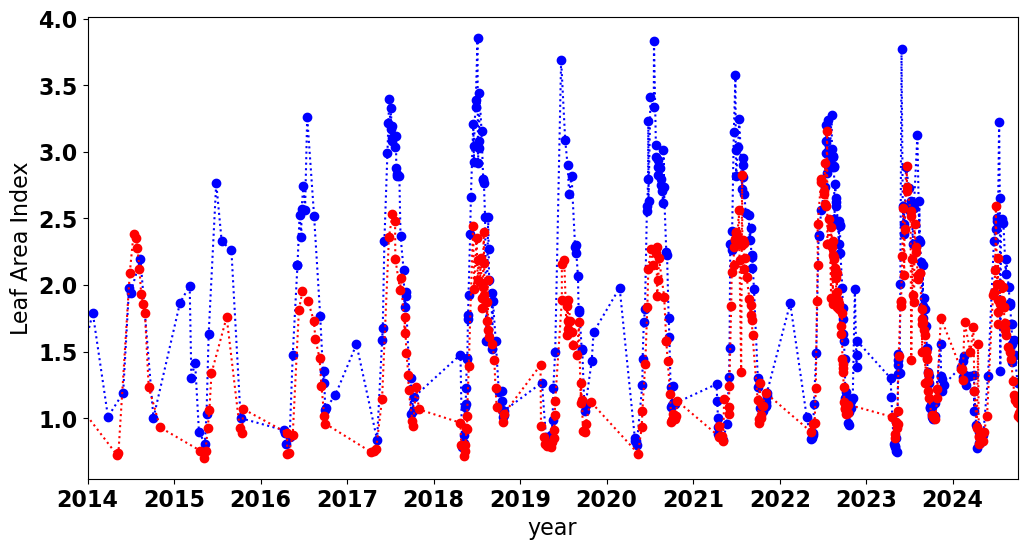

In [315]:
qtile = 0.5
qtilebuffer = 0.5
#actually buffers
dfsample_wellsHLSL30LAI = pd.DataFrame(HLSL30LAI['projects/ee-modis250/assets/sample_wells'])
dfsample_wellsHLSL30LAI ['SL2PVMIXdaily'] = dfsample_wellsHLSL30LAI ['SL2PVMIX'].apply(lambda site:   site.loc[(site['QC']==0) ][['date','estimateLAI']].groupby(['date']).quantile(q=qtilebuffer,interpolation='lower').reset_index())
dfsample_wellsHLSL30LAI ['SL2PVMIXdaily'] =  dfsample_wellsHLSL30LAI ['SL2PVMIXdaily'].apply(lambda site: pd.concat([site['estimateLAI'],pd.to_datetime(site['date'],unit='ms')],axis=1))

dfsample_wellsHLSS30LAI = pd.DataFrame(HLSS30LAI['projects/ee-modis250/assets/sample_wells'])
dfsample_wellsHLSS30LAI ['SL2PVMIXdaily'] = dfsample_wellsHLSS30LAI ['SL2PVMIX'].apply(lambda site:   site.loc[(site['QC']==0) ][['date','estimateLAI']].groupby(['date']).quantile(q=qtilebuffer,interpolation='lower').reset_index())
dfsample_wellsHLSS30LAI ['SL2PVMIXdaily'] =  dfsample_wellsHLSS30LAI ['SL2PVMIXdaily'].apply(lambda site: pd.concat([site['estimateLAI'],pd.to_datetime(site['date'],unit='ms')],axis=1))

dfsample_wellsS2LAI = pd.DataFrame(S2LAI['projects/ee-modis250/assets/sample_wells'])
dfsample_wellsS2LAI ['SL2PVMIXdaily'] = dfsample_wellsS2LAI ['SL2PVMIX'].apply(lambda site:   site.loc[(site['QC']==0) ][['date','estimateLAI']].groupby(['date']).quantile(q=qtilebuffer,interpolation='lower').reset_index())
dfsample_wellsS2LAI ['SL2PVMIXdaily'] =  dfsample_wellsS2LAI ['SL2PVMIXdaily'].apply(lambda site: pd.concat([site['estimateLAI'],pd.to_datetime(site['date'],unit='ms')],axis=1))
df = pd.concat([dfsample_wellsHLSS30LAI[['feature','SL2PVMIXdaily']].rename(columns={'SL2PVMIXdaily':'SL2PVMIXdailyHLSS30'}),dfsample_wellsHLSL30LAI.rename(columns={'SL2PVMIXdaily':'SL2PVMIXdailyHLSL30'})],axis=1)
# print(df[['SL2PVMIXdailyHLSS30','SL2PVMIXdailyHLSL30']])
# df['SL2PVMIXdaily'] = df[['SL2PVMIXdailyHLSS30','SL2PVMIXdailyHLSL30']].apply(lambda site: pd.concat([site['SL2PVMIXdailyHLSS30'],site['SL2PVMIXdailyHLSL30']],axis=1))

#actually wells
dfsample_buffersHLSL30LAI = pd.DataFrame(HLSL30LAI['projects/ee-modis250/assets/sample_wells_reference_buffers'])
dfsample_buffersHLSL30LAI ['SL2PVMIXdaily'] = dfsample_buffersHLSL30LAI ['SL2PVMIX'].apply(lambda site:   site.loc[(site['QC']==0) ][['date','estimateLAI']].groupby(['date']).quantile(q=qtile,interpolation='lower').reset_index())
dfsample_buffersHLSL30LAI ['SL2PVMIXdaily'] =  dfsample_buffersHLSL30LAI ['SL2PVMIXdaily'].apply(lambda site: pd.concat([site['estimateLAI'],pd.to_datetime(site['date'],unit='ms')],axis=1))

dfsample_buffersHLSS30LAI = pd.DataFrame(HLSS30LAI['projects/ee-modis250/assets/sample_wells_reference_buffers'])
dfsample_buffersHLSS30LAI ['SL2PVMIXdaily'] = dfsample_buffersHLSS30LAI ['SL2PVMIX'].apply(lambda site:   site.loc[(site['QC']==0) ][['date','estimateLAI']].groupby(['date']).quantile(q=qtile,interpolation='lower').reset_index())
dfsample_buffersHLSS30LAI ['SL2PVMIXdaily'] =  dfsample_buffersHLSS30LAI ['SL2PVMIXdaily'].apply(lambda site: pd.concat([site['estimateLAI'],pd.to_datetime(site['date'],unit='ms')],axis=1))

dfsample_buffersS2LAI = pd.DataFrame(S2LAI['projects/ee-modis250/assets/sample_wells_reference_buffers'])
dfsample_buffersS2LAI ['SL2PVMIXdaily'] = dfsample_buffersS2LAI ['SL2PVMIX'].apply(lambda site:   site.loc[(site['QC']==0) ][['date','estimateLAI']].groupby(['date']).quantile(q=qtile,interpolation='lower').reset_index())
dfsample_buffersS2LAI ['SL2PVMIXdaily'] =  dfsample_buffersS2LAI ['SL2PVMIXdaily'].apply(lambda site: pd.concat([site['estimateLAI'],pd.to_datetime(site['date'],unit='ms')],axis=1))


plot = 1
plt.rcParams.update({'font.size': 16})
date1 = datetime.date(2014,1,1)
date2 = datetime.date(2024,10,1)
fix,axs = plt.subplots(1,1,figsize=(12,6))
df = pd.concat([dfsample_wellsHLSS30LAI ['SL2PVMIXdaily'][plot],dfsample_wellsHLSL30LAI ['SL2PVMIXdaily'][plot]]).sort_values(['date'])
axs.plot(df['date'],df['estimateLAI'],'bo:')
df = pd.concat([dfsample_buffersHLSS30LAI ['SL2PVMIXdaily'][plot],dfsample_buffersHLSL30LAI ['SL2PVMIXdaily'][plot]]).sort_values(['date'])
axs.plot(df['date'],df['estimateLAI'],'ro:')
axs.set_xlabel('year')
axs.set_ylabel('Leaf Area Index')
# df = pd.concat([dfsample_buffersS2LAI ['SL2PVMIXdaily'][plot],dfsample_buffersS2LAI ['SL2PVMIXdaily'][plot]]).sort_values(['date'])
# axs.plot(df['date'],df['estimateLAI'],'k.')
axs.set_xlim(date1,date2)

In [298]:
qtile = 0.25
qtilebuffer = 0.5
#actually buffers
dfsample_wellsHLSL30fCOVER = pd.DataFrame(HLSL30fCOVER['projects/ee-modis250/assets/sample_wells'])
dfsample_wellsHLSL30fCOVER ['SL2PVMIXdaily'] = dfsample_wellsHLSL30fCOVER ['SL2PVMIX'].apply(lambda site:   site.loc[(site['QC']==0) ][['date','estimatefCOVER']].groupby(['date']).quantile(q=qtilebuffer,interpolation='lower').reset_index())
dfsample_wellsHLSL30fCOVER ['SL2PVMIXdaily'] =  dfsample_wellsHLSL30fCOVER ['SL2PVMIXdaily'].apply(lambda site: pd.concat([site['estimatefCOVER'],pd.to_datetime(site['date'],unit='ms')],axis=1))

dfsample_wellsHLSS30fCOVER = pd.DataFrame(HLSS30fCOVER['projects/ee-modis250/assets/sample_wells'])
dfsample_wellsHLSS30fCOVER ['SL2PVMIXdaily'] = dfsample_wellsHLSS30fCOVER ['SL2PVMIX'].apply(lambda site:   site.loc[(site['QC']==0) ][['date','estimatefCOVER']].groupby(['date']).quantile(q=qtilebuffer,interpolation='lower').reset_index())
dfsample_wellsHLSS30fCOVER ['SL2PVMIXdaily'] =  dfsample_wellsHLSS30fCOVER ['SL2PVMIXdaily'].apply(lambda site: pd.concat([site['estimatefCOVER'],pd.to_datetime(site['date'],unit='ms')],axis=1))

dfsample_wellsS2fCOVER = pd.DataFrame(S2fCOVER['projects/ee-modis250/assets/sample_wells'])
dfsample_wellsS2fCOVER ['SL2PVMIXdaily'] = dfsample_wellsS2fCOVER ['SL2PVMIX'].apply(lambda site:   site.loc[(site['QC']==0) ][['date','estimatefCOVER']].groupby(['date']).quantile(q=qtilebuffer,interpolation='lower').reset_index())
dfsample_wellsS2fCOVER ['SL2PVMIXdaily'] =  dfsample_wellsS2fCOVER ['SL2PVMIXdaily'].apply(lambda site: pd.concat([site['estimatefCOVER'],pd.to_datetime(site['date'],unit='ms')],axis=1))
df = pd.concat([dfsample_wellsHLSS30fCOVER[['feature','SL2PVMIXdaily']].rename(columns={'SL2PVMIXdaily':'SL2PVMIXdailyHLSS30'}),dfsample_wellsHLSL30fCOVER.rename(columns={'SL2PVMIXdaily':'SL2PVMIXdailyHLSL30'})],axis=1)
# print(df[['SL2PVMIXdailyHLSS30','SL2PVMIXdailyHLSL30']])
# df['SL2PVMIXdaily'] = df[['SL2PVMIXdailyHLSS30','SL2PVMIXdailyHLSL30']].apply(lambda site: pd.concat([site['SL2PVMIXdailyHLSS30'],site['SL2PVMIXdailyHLSL30']],axis=1))

#actually wells
dfsample_buffersHLSL30fCOVER = pd.DataFrame(HLSL30fCOVER['projects/ee-modis250/assets/sample_wells_reference_buffers'])
dfsample_buffersHLSL30fCOVER ['SL2PVMIXdaily'] = dfsample_buffersHLSL30fCOVER ['SL2PVMIX'].apply(lambda site:   site.loc[(site['QC']==0) ][['date','estimatefCOVER']].groupby(['date']).quantile(q=qtile,interpolation='lower').reset_index())
dfsample_buffersHLSL30fCOVER ['SL2PVMIXdaily'] =  dfsample_buffersHLSL30fCOVER ['SL2PVMIXdaily'].apply(lambda site: pd.concat([site['estimatefCOVER'],pd.to_datetime(site['date'],unit='ms')],axis=1))

dfsample_buffersHLSS30fCOVER = pd.DataFrame(HLSS30fCOVER['projects/ee-modis250/assets/sample_wells_reference_buffers'])
dfsample_buffersHLSS30fCOVER ['SL2PVMIXdaily'] = dfsample_buffersHLSS30fCOVER ['SL2PVMIX'].apply(lambda site:   site.loc[(site['QC']==0) ][['date','estimatefCOVER']].groupby(['date']).quantile(q=qtile,interpolation='lower').reset_index())
dfsample_buffersHLSS30fCOVER ['SL2PVMIXdaily'] =  dfsample_buffersHLSS30fCOVER ['SL2PVMIXdaily'].apply(lambda site: pd.concat([site['estimatefCOVER'],pd.to_datetime(site['date'],unit='ms')],axis=1))

dfsample_buffersS2fCOVER = pd.DataFrame(S2fCOVER['projects/ee-modis250/assets/sample_wells_reference_buffers'])
dfsample_buffersS2fCOVER ['SL2PVMIXdaily'] = dfsample_buffersS2fCOVER ['SL2PVMIX'].apply(lambda site:   site.loc[(site['QC']==0) ][['date','estimatefCOVER']].groupby(['date']).quantile(q=qtile,interpolation='lower').reset_index())
dfsample_buffersS2fCOVER ['SL2PVMIXdaily'] =  dfsample_buffersS2fCOVER ['SL2PVMIXdaily'].apply(lambda site: pd.concat([site['estimatefCOVER'],pd.to_datetime(site['date'],unit='ms')],axis=1))


plot = 1

date1 = datetime.date(2014,1,1)
date2 = datetime.date(2024,10,1)
fix,axs = plt.subplots(1,1,figsize=(12,6))
df = pd.concat([dfsample_wellsHLSS30fCOVER ['SL2PVMIXdaily'][plot],dfsample_wellsHLSL30fCOVER ['SL2PVMIXdaily'][plot]]).sort_values(['date'])
axs.plot(df['date'],df['estimatefCOVER'],'bo:')
df = pd.concat([dfsample_buffersHLSS30fCOVER ['SL2PVMIXdaily'][plot],dfsample_buffersHLSL30fCOVER ['SL2PVMIXdaily'][plot]]).sort_values(['date'])
axs.plot(df['date'],df['estimatefCOVER'],'ro:')
# df = pd.concat([dfsample_buffersS2fCOVER ['SL2PVMIXdaily'][plot],dfsample_buffersS2fCOVER ['SL2PVMIXdaily'][plot]]).sort_values(['date'])
# axs.plot(df['date'],df['estimatefCOVER'],'k.')
axs.set_xlim(date1,date2)

NameError: name 'HLSL30fCOVER' is not defined

(18993.0, 19997.0)

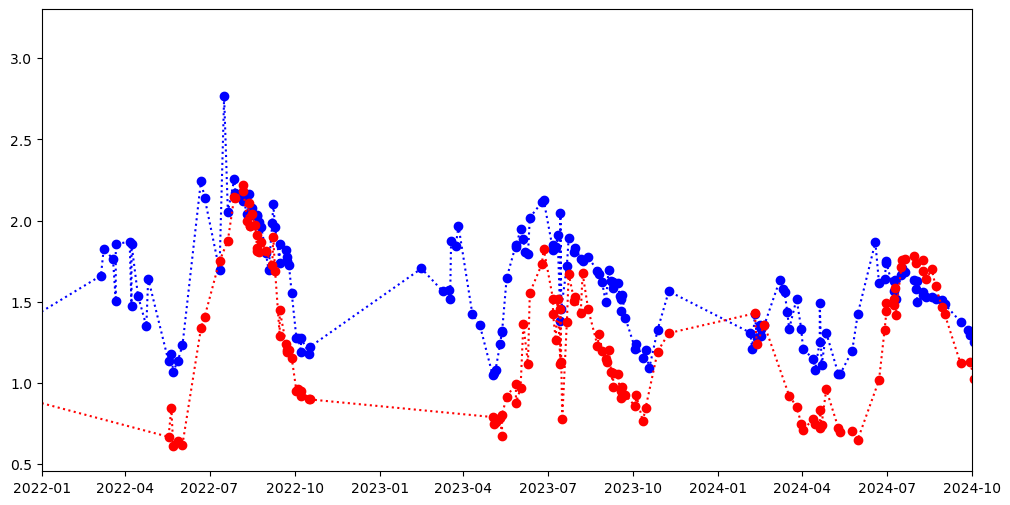

In [115]:
#plot 1
dfbuffer1 = pd.DataFrame(HLSS30LAI['projects/ee-modis250/assets/sample_wells'][1]['SL2PVMIX'])
dfbuffer1Daily = dfbuffer1.loc[(dfbuffer1['QC']==0) ][['date','estimateLAI']].groupby(['date']).quantile(q=qtile).reset_index()
dfbuffer1Daily['doy'] = pd.to_datetime(dfbuffer1Daily['date'], unit='ms')
print(dfbuffer1Daily)

df1 = pd.DataFrame(HLSS30LAI['projects/ee-modis250/assets/sample_wells_reference_buffers'][1]['SL2PVMIX'])
df1Daily = df1.loc[(df1['QC']==0) ][['date','estimateLAI']].groupby(['date']).quantile(q=qtile).reset_index()
df1Daily['doy'] = pd.to_datetime(df1Daily['date'], unit='ms')
print(df1Daily)

              date  estimateLAI                 doy
0    1460486572000     0.801796 2016-04-12 18:42:52
1    1462214362000     0.745511 2016-05-02 18:39:22
2    1463338162000     1.123478 2016-05-15 18:49:22
3    1465066162000     1.846143 2016-06-04 18:49:22
4    1466534902000     2.335184 2016-06-21 18:48:22
..             ...          ...                 ...
245  1728586391000     1.110354 2024-10-10 18:53:11
246  1728758549000     0.939082 2024-10-12 18:42:29
247  1729622619000     1.220945 2024-10-22 18:43:39
248  1729882439000     0.996970 2024-10-25 18:53:59
249  1730746489000     1.353481 2024-11-04 18:54:49

[250 rows x 3 columns]
              date  estimateLAI                 doy
0    1461265822000     0.855888 2016-04-21 19:10:22
1    1465585762000     1.659098 2016-06-10 19:09:22
2    1473101952000     1.397247 2016-09-05 18:59:12
3    1474830082000     0.939532 2016-09-25 19:01:22
4    1498417751000     2.062715 2017-06-25 19:09:11
..             ...          ...         

In [118]:
#plot 1
dfbuffer1 = pd.DataFrame(S2LAI['projects/ee-modis250/assets/sample_wells'][1]['SL2PVMIX'])
dfbuffer1Daily = dfbuffer1.loc[(dfbuffer1['QC']==0) & (dfbuffer1['s2cloudless_probability']<0.50)][['date','estimateLAI']].groupby(['date']).quantile(q=qtile).reset_index()
dfbuffer1Daily['doy'] = pd.to_datetime(dfbuffer1Daily['date'], unit='ms')
print(dfbuffer1Daily)

df1 = pd.DataFrame(S2LAI['projects/ee-modis250/assets/sample_wells_reference_buffers'][1]['SL2PVMIX'])
df1Daily = df1.loc[(df1['QC']==0) & (df1['s2cloudless_probability']<0.50)][['date','estimateLAI']].groupby(['date']).quantile(q=qtile).reset_index()
df1Daily['doy'] = pd.to_datetime(df1Daily['date'], unit='ms')
print(df1Daily)

             date  estimateLAI                     doy
0   1557514738000     0.457225 2019-05-10 18:58:58.000
1   1558118941000     0.705368 2019-05-17 18:49:01.000
2   1558378738000     0.644183 2019-05-20 18:58:58.000
3   1564166942966     4.120345 2019-07-26 18:49:02.966
4   1566326943568     2.224567 2019-08-20 18:49:03.568
5   1568314735673     1.219523 2019-09-12 18:58:55.673
6   1588790935628     0.212218 2020-05-06 18:48:55.628
7   1591814944353     1.415215 2020-06-10 18:49:04.353
8   1592074741254     2.157203 2020-06-13 18:59:01.254
9   1592678943950     4.246079 2020-06-20 18:49:03.950
10  1592938740757     3.701837 2020-06-23 18:59:00.757
11  1595962737673     3.375807 2020-07-28 18:58:57.673
12  1596394740965     2.424445 2020-08-02 18:59:00.965
13  1596566941197     3.447961 2020-08-04 18:49:01.197
14  1596998944049     4.471984 2020-08-09 18:49:04.049
15  1597690738600     3.669908 2020-08-17 18:58:58.600
16  1621622938019     0.557288 2021-05-21 18:48:58.019
17  162248

In [62]:
df = pd.DataFrame(S2LAI['projects/ee-modis250/assets/sample_wells'])

df2 = df['SL2PVMIX']
result = df['SL2PVMIX'].apply(lambda row: row[['date','estimateLAI']].groupby(['date']).quantile(q=qtile).reset_index())
result2 =  result.apply(lambda row: rowd

In [74]:
df


,feature,SL2PVMIX
0,"{'1': 572.8013883104511, '2': 167.003552859437...",date QC longitude latitud...
1,"{'1': 7899.034735481413, '3': 2948.18439456715...",date QC longitude latitud...
2,"{'1': 616.8066142512304, '2': 1577.35382268569...",date QC longitude latitud...
3,"{'1': 179.62394101011986, '2': 1052.7795448004...",date QC longitude latitud...


In [ ]:
HLSS30fCOVER= LEAFv2.sampleSites(siteList, \
                                                imageCollectionName="NASA/HLS/HLSS30/v002",\
                                                algorithm=SL2PVMIX, 
                                                variableName="fCOVER",\
                                                maxCloudcover=90,
                                                outputScaleSize=30,\
                                                inputScaleSize=30,\
                                                bufferSpatialSize = 0,\
                                                bufferTemporalSize =["2016-01-01","2024-12-31"],  \
                                                subsamplingFraction = 0.99,\
                                                feature_range=[0,5])

HLSL30fCOVER= LEAFv2.sampleSites(siteList, \
                                                imageCollectionName="NASA/HLS/HLSL30/v002",\
                                                algorithm=SL2PVMIX, 
                                                variableName="fCOVER",\
                                                maxCloudcover=90,
                                                outputScaleSize=30,\
                                                inputScaleSize=30,\
                                                bufferSpatialSize = 0,\
                                                bufferTemporalSize =["2013-01-01","2024-12-31"],  \
                                                subsamplingFraction = 0.99,\
                                                feature_range=[0,5])
S2fCOVER= LEAFv2.sampleSites(siteList, \
                                                imageCollectionName="COPERNICUS/S2_SR_HARMONIZED",\
                                                algorithm=SL2PVMIX, 
                                                variableName="fCOVER",\
                                                maxCloudcover=90,
                                                outputScaleSize=20,\
                                                inputScaleSize=20,\
                                                bufferSpatialSize = 0,\
                                                bufferTemporalSize =["2016-01-01","2024-12-31"],  \
                                                subsamplingFraction = 0.99,\
                                                feature_range=[0,5])